# Caso práctico: Random Forest

En este caso de uso práctico se pretende resolver un problema de detección de malware en disitivos Android mediante el anaálsis de tráfico de red que genera el dispostivo mediante el uso de conjunto de árboles de desición.

## Description

The sophisticated and advanced Android malware is able to identify the presence of the emulator used by the malware analyst and in response, alter its behaviour to evade detection. To overcome this issue, we installed the Android applications on the real device and captured its network traffic. 

CICAAGM dataset is captured by installing the Android apps on the real smartphones semi-automated. The dataset is generated from 1,900 applications with the following three categories:

**1. Adware (250 apps)**
* **Airpush**: Designed to deliver unsolicited advertisements to the user’s systems for information stealing.
* **Dowgin**: Designed as an advertisement library that can also steal the user’s information.
* **Kemoge**: Designed to take over a user’s Android device. This adware is a hybrid of botnet and disguises itself as popular apps via repackaging.
* **Mobidash**: Designed to display ads and to compromise user’s personal information.
* **Shuanet**: Similar to Kemoge, Shuanet is also designed to take over a user’s device.

**2. General Malware (150 apps)**
* **AVpass**: Designed to be distributed in the guise of a Clock app.
* **FakeAV**: Designed as a scam that tricks user to purchase a full version of the software in order to re-mediate non-existing infections.
* **FakeFlash/FakePlayer**: Designed as a fake Flash app in order to direct users to a website (after successfully installed).
* **GGtracker**: Designed for SMS fraud (sends SMS messages to a premium-rate number) and information stealing.
* **Penetho**: Designed as a fake service (hacktool for Android devices that can be used to crack the WiFi password). The malware is also able to infect the user’s computer via infected email attachment, fake updates, external media and infected documents.

**3. Benign (1,500 apps)**
* 2015 GooglePlay market (top free popular and top free new)
* 2016 GooglePlay market (top free popular and top free new)

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from pandas import DataFrame

### Funciones Auxiliares

In [2]:
# Construcción de una función que realice al particionado completo

def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
# Separa el dataframe de label_name y se la genera en otro datraframe (y)

def remove_labels(df, label_name):
    X = df.drop(label_name, axis = 1)
    y = df[label_name].copy()
    return(X, y)

In [4]:
# permite comparar el rendimient con una una preparación y sin preparación del modelo de aprendizaje
# metric es la metrica de comparación

def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, ' Whithout preparation: ', metric(y_pred, y, average ='weighted'))
    print(metric.__name__, ' Whith preparation: ', metric(y_prep_pred, y_prep, average ='weighted'))

### 1.- Lectura del DataSet

In [ ]:
df = pd.read_csv('datasets/datasets/TotalFeatures-ISCXFlowMeter.csv')

### 2. Visualización del DataSet

In [6]:
df.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
0,1020586,668,1641,35692,2276876,52,52,679,1390,53.431138,...,0.0,-1,0.0,2,4194240,1853440,1640,668,32,benign
1,80794,1,1,75,124,75,124,75,124,75.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
2,998,3,0,187,0,52,-1,83,-1,62.333333,...,0.0,-1,0.0,4,101888,-1,0,3,32,benign
3,189868,9,9,1448,6200,52,52,706,1390,160.888889,...,0.0,-1,0.0,2,4194240,2722560,8,9,32,benign
4,110577,4,6,528,1422,52,52,331,1005,132.000000,...,0.0,-1,0.0,2,155136,31232,5,4,32,benign
5,261876,7,6,1618,882,52,52,730,477,231.142857,...,0.0,-1,0.0,2,4194240,926720,3,7,32,benign
6,14,2,0,104,0,52,-1,52,-1,52.000000,...,0.0,-1,0.0,3,5824,-1,0,2,32,benign
7,29675,1,1,71,213,71,213,71,213,71.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
8,806635,4,0,239,0,52,-1,83,-1,59.750000,...,0.0,-1,0.0,5,107008,-1,0,4,32,benign
9,56620,3,2,1074,719,52,52,592,667,358.000000,...,0.0,-1,0.0,3,128512,10816,1,3,32,benign


In [7]:
df.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,6.319550e+05,631955.000000,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.000000,631955.000000,631955.000000,631955.000000,...,6.319550e+05,6.319550e+05,6.319550e+05,6.319550e+05,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.00000,631955.000000
mean,2.195245e+07,6.728514,10.431934,9.540172e+02,1.206042e+04,141.475727,44.357688,263.675901,183.248084,174.959706,...,1.997327e+07,2.031228e+07,2.075238e+07,4.663875e+05,2.360896,9.620796e+05,3.104519e+05,9.733144,6.72471,19.965713
std,1.900578e+08,174.161354,349.424019,8.235040e+04,4.824716e+05,157.680880,89.099554,289.644383,371.863224,162.024811,...,1.897986e+08,1.897902e+08,1.899721e+08,6.199704e+06,3.041810,1.705655e+06,6.647956e+05,347.877923,174.13813,14.914261
min,-1.800000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,-1.000000e+00,-1.000000e+00,0.000000,0.00000,0.000000
25%,0.000000e+00,1.000000,0.000000,6.900000e+01,0.000000e+00,52.000000,-1.000000,52.000000,-1.000000,52.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,0.000000e+00,-1.000000e+00,0.000000,1.00000,0.000000
50%,2.445000e+04,1.000000,0.000000,1.840000e+02,0.000000e+00,52.000000,-1.000000,83.000000,-1.000000,83.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,8.761600e+04,-1.000000e+00,0.000000,1.00000,32.000000
75%,1.759751e+06,3.000000,1.000000,4.270000e+02,1.670000e+02,108.000000,52.000000,421.000000,115.000000,356.000000,...,1.013498e+06,1.291379e+06,1.306116e+06,0.000000e+00,2.000000,3.046400e+05,9.049600e+04,1.000000,3.00000,32.000000
max,4.431076e+10,48255.000000,74768.000000,4.049644e+07,1.039222e+08,1390.000000,1390.000000,1500.000000,1390.000000,1390.000000,...,4.431072e+10,4.430000e+10,4.431072e+10,8.470000e+08,2269.000000,4.194240e+06,4.194240e+06,74524.000000,48255.00000,44.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631955 entries, 0 to 631954
Data columns (total 80 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration                 631955 non-null  int64  
 1   total_fpackets           631955 non-null  int64  
 2   total_bpackets           631955 non-null  int64  
 3   total_fpktl              631955 non-null  int64  
 4   total_bpktl              631955 non-null  int64  
 5   min_fpktl                631955 non-null  int64  
 6   min_bpktl                631955 non-null  int64  
 7   max_fpktl                631955 non-null  int64  
 8   max_bpktl                631955 non-null  int64  
 9   mean_fpktl               631955 non-null  float64
 10  mean_bpktl               631955 non-null  float64
 11  std_fpktl                631955 non-null  float64
 12  std_bpktl                631955 non-null  float64
 13  total_fiat               631955 non-null  int64  
 14  tota

In [9]:
print('Longitud del DataSet: ', len(df))
print('Número de características: ', len(df.columns))

Longitud del DataSet:  631955
Número de características:  80


In [10]:
df['calss'].value_counts()

calss
benign            471597
asware            155613
GeneralMalware      4745
Name: count, dtype: int64

#### Buscando correlaciones

In [11]:
# Transformar la variable de salida a númerica para calcular correlaciones

X = df.copy()
X['calss'] = X['calss'].factorize()[0]
corr_matrix = X.corr()
corr_matrix['calss'].sort_values(ascending=False)

calss                     1.000000
flow_fin                  0.286175
min_seg_size_forward      0.258352
Init_Win_bytes_forward    0.129425
std_fpktl                 0.123758
                            ...   
furg_cnt                       NaN
burg_cnt                       NaN
flow_urg                       NaN
flow_cwr                       NaN
flow_ece                       NaN
Name: calss, Length: 80, dtype: float64

In [12]:
X.corr()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004837,0.004011,0.001673,0.003518,-0.064100,-0.027231,0.008761,0.042925,-0.043746,...,0.998901,0.999458,0.047582,0.016532,0.027610,0.029712,0.003785,0.004838,0.082955,0.067066
total_fpackets,0.004837,1.000000,0.924622,0.425756,0.904007,-0.018958,0.005252,0.024685,0.086255,-0.007910,...,0.001614,0.002267,0.017229,0.016089,0.050201,0.059224,0.902713,0.999866,0.018198,0.018377
total_bpackets,0.004011,0.924622,1.000000,0.156780,0.997268,-0.017667,0.006912,0.018170,0.086886,-0.016104,...,0.000922,0.001617,0.016230,-0.000493,0.048190,0.058435,0.997580,0.924746,0.015124,0.019430
total_fpktl,0.001673,0.425756,0.156780,1.000000,0.090082,-0.003099,0.000803,0.021278,0.022088,0.022409,...,0.000335,0.000609,0.009896,0.001657,0.013283,0.015991,0.088422,0.425789,0.005477,0.000679
total_bpktl,0.003518,0.904007,0.997268,0.090082,1.000000,-0.014926,0.005966,0.012560,0.079905,-0.017328,...,0.000812,0.001452,0.014336,-0.000293,0.043571,0.053134,0.999616,0.904129,0.012139,0.019838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Init_Win_bytes_backward,0.029712,0.059224,0.058435,0.015991,0.053134,-0.268444,0.038319,0.429893,0.593143,-0.030004,...,0.026959,0.029512,0.097316,-0.052507,0.811204,1.000000,0.056761,0.059242,0.333701,0.069405
RRT_samples_clnt,0.003785,0.902713,0.997580,0.088422,0.999616,-0.016659,0.006156,0.015727,0.084280,-0.017595,...,0.000893,0.001560,0.015200,-0.000437,0.046784,0.056761,1.000000,0.902834,0.014299,0.019679
Act_data_pkt_forward,0.004838,0.999866,0.924746,0.425789,0.904129,-0.018947,0.005264,0.024705,0.086278,-0.007893,...,0.001617,0.002269,0.017233,0.000734,0.050220,0.059242,0.902834,1.000000,0.018229,0.018391
min_seg_size_forward,0.082955,0.018198,0.015124,0.005477,0.012139,-0.686154,-0.189824,-0.074763,0.217989,-0.524024,...,0.077943,0.079324,0.048803,0.052177,0.394743,0.333701,0.014299,0.018229,1.000000,0.258352


In [13]:
# Se puede llegar a valorar quedarse con aquellas que tienen mayor correlación

corr_matrix[corr_matrix['calss'] > 0.05]

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004837,0.004011,0.001673,0.003518,-0.064100,-0.027231,0.008761,0.042925,-0.043746,...,0.998901,0.999458,0.047582,0.016532,0.027610,0.029712,0.003785,0.004838,0.082955,0.067066
max_bpktl,0.042925,0.086255,0.086886,0.022088,0.079905,-0.277317,0.275923,0.492194,1.000000,-0.018358,...,0.035413,0.038732,0.127548,-0.044916,0.586742,0.593143,0.084280,0.086278,0.217989,0.073212
mean_bpktl,0.025117,0.139142,0.151761,0.018954,0.146437,-0.280648,0.465208,0.342392,0.895712,-0.096195,...,0.018533,0.021519,0.114949,-0.045442,0.452735,0.478823,0.150252,0.139172,0.122226,0.064753
std_fpktl,0.039350,0.010172,0.002331,0.011416,-0.003162,-0.245792,0.052877,0.817873,0.564243,0.259588,...,0.031418,0.033978,0.096844,-0.020885,0.558249,0.532900,0.000140,0.010182,0.301237,0.123758
std_bpktl,0.048743,0.020324,0.014005,0.007763,0.007768,-0.225143,0.035371,0.534532,0.941626,0.051756,...,0.042562,0.045450,0.113854,-0.033991,0.594790,0.577954,0.012050,0.020335,0.276055,0.072953
total_fiat,0.943898,0.002190,0.001718,0.000708,0.001546,-0.049879,-0.031218,-0.029233,-0.005961,-0.048869,...,0.943668,0.943339,0.015254,0.020302,-0.011637,-0.016421,0.001615,0.002190,0.065124,0.064770
min_fiat,0.841692,-0.001975,-0.002172,-0.000746,-0.001820,-0.040046,-0.036619,-0.052289,-0.035963,-0.053811,...,0.843330,0.842512,-0.005389,0.015316,-0.027350,-0.033944,-0.002037,-0.001974,0.051853,0.074491
max_fiat,0.943438,-0.000420,-0.000714,-0.000389,-0.000548,-0.046977,-0.032630,-0.032606,-0.009878,-0.049032,...,0.944412,0.943971,0.012557,0.017756,-0.012317,-0.016206,-0.000644,-0.000418,0.061285,0.064875
mean_fiat,0.918036,-0.001970,-0.002241,-0.000728,-0.001907,-0.042455,-0.036056,-0.048712,-0.032412,-0.052892,...,0.919653,0.918797,-0.003523,0.016958,-0.025823,-0.032466,-0.002113,-0.001968,0.055151,0.071397
std_flowpktl,0.036942,0.087741,0.087307,0.024298,0.080666,-0.262968,0.338513,0.631466,0.911584,0.095976,...,0.030013,0.033100,0.120257,-0.035737,0.580266,0.586355,0.084725,0.087764,0.219346,0.119375


### 3. Divisón del DataSet

In [14]:
train_set, val_set, test_set = train_val_test_split(X)

In [15]:
X_train, y_train = remove_labels(train_set, 'calss')
X_val, y_val = remove_labels(val_set, 'calss')
X_test, y_test = remove_labels(test_set, 'calss')

### 4. Escalado del DataSet

Es importante  comprender que los árboles de desición son algoritmos que **No requieren demasiada preparación de los datos** concretamente, no requieren la realización o escalado o normalización. En este ejercicio se va a realizar escalado al DataSet y se van a comprar los resultados con el DataSet sin escalar. De está manera se demuestra como aplicar preprocesamientos de como el escalado puede llegar a afectar al rendimiento del modelo.

In [16]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [17]:
scaler = RobustScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [18]:
scaler = RobustScaler()
X_val_scaled = scaler.fit_transform(X_val)

In [19]:
# Transformar el DataSet a un DataFrame de pandas

X_train_scaled = DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_scaled.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
508881,-0.013646,0.0,1.0,-0.310056,1.556886,0.375000,4.924528,-0.027100,2.250000,-0.032895,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000011,0.0,0.0,-1.0
208326,-0.013926,0.0,0.0,0.664804,0.000000,6.607143,0.000000,0.918699,0.000000,1.115132,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
107213,-0.013926,0.0,0.0,0.703911,0.000000,6.857143,0.000000,0.956640,0.000000,1.161184,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
466726,-0.000273,0.0,1.0,-0.363128,2.724551,0.035714,8.603774,-0.078591,3.931034,-0.095395,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000011,0.0,0.0,-1.0
230085,-0.013926,0.0,0.0,0.664804,0.000000,6.607143,0.000000,0.918699,0.000000,1.115132,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
472961,34.421927,1.5,4.0,1.558659,3.868263,0.000000,1.000000,1.341463,4.163793,0.337171,...,59.657102,48.116772,47.580946,0.0,0.0,13.421042,12.657580,3.0,1.5,0.0
482372,-0.013805,0.5,0.0,-0.136872,0.000000,0.000000,0.000000,0.000000,0.000000,-0.050987,...,0.000000,0.000000,0.000000,0.0,1.0,-0.080736,0.000000,0.0,0.5,0.0
619993,17.578734,0.5,0.0,-0.050279,0.000000,0.553571,0.000000,0.000000,0.000000,0.000000,...,30.549478,24.617883,24.365465,0.0,1.0,0.063376,0.000000,0.0,0.5,0.0
65344,-0.013926,0.0,0.0,0.703911,0.000000,6.857143,0.000000,0.956640,0.000000,1.161184,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
46666,-0.013926,0.0,0.0,0.505587,0.000000,5.589286,0.000000,0.764228,0.000000,0.927632,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0


In [20]:
X_train_scaled.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,...,379173.000000,379173.000000,379173.000000,3.791730e+05,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000
mean,12.543409,2.927643,10.762678,1.947184,75.104138,1.600682,0.855241,0.491724,1.591823,0.303639,...,19.838596,16.279309,16.441899,4.686618e+05,0.362658,2.861506,3.435883,10.087709,2.924548,-0.376798
std,116.165117,92.319402,370.875546,185.549801,3071.968461,2.817301,1.676098,0.786500,3.210186,0.533388,...,201.477623,162.562856,160.822696,6.188642e+06,3.836035,5.577212,7.354164,369.660712,92.301146,0.466297
min,-0.013936,-0.500000,0.000000,-0.513966,0.000000,-0.946429,0.000000,-0.227642,0.000000,-0.273026,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.286345,0.000000,0.000000,-0.500000,-1.000000
25%,-0.013926,0.000000,0.000000,-0.321229,0.000000,0.000000,0.000000,-0.084011,0.000000,-0.101974,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.286342,0.000000,0.000000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.986074,1.000000,1.000000,0.678771,1.000000,1.000000,1.000000,0.915989,1.000000,0.898026,...,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.713658,1.000000,1.000000,1.000000,0.000000
max,25277.128872,24127.000000,74768.000000,113118.041899,622288.473054,23.892857,26.245283,3.840108,11.991379,4.299342,...,43893.471528,35408.189283,35008.286082,5.670000e+08,2267.000000,13.421042,46.346741,74524.000000,24127.000000,0.375000


### 5. Dessision Forest

#### 5.1. Entrenamiento y predicción de los datos de entrenamiento

In [21]:
from sklearn.tree import DecisionTreeClassifier

# modelo entrenado con el DataSet sin escalar
clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [22]:
# modelo entrenado con el DataSet escalado

clf_tree_scaled = DecisionTreeClassifier(random_state=42)
clf_tree_scaled.fit(X_train_scaled, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [23]:
# pedecir con el DataSet de entrenamiendo

y_train_pred = clf_tree.predict(X_train)
y_train_prep_pred = clf_tree_scaled.predict(X_train_scaled)

In [24]:
# Comparación de los resultados

evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)

f1_score  Whithout preparation:  0.981274676726902
f1_score  Whith preparation:  0.9812850807687135


#### 5.2. Entrenamiento y predicción con los datos de validación

In [25]:
# predicción con el DataSet de validación

y_val_pred = clf_tree.predict(X_val)
y_val_prep_pred = clf_tree_scaled.predict(X_val_scaled)

/home/terrazas/anaconda3/envs/PLyF/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [26]:
# Evaluación de resultados

evaluate_result(y_val_pred, y_val, y_val_prep_pred, y_val, f1_score)

f1_score  Whithout preparation:  0.9305558954019816
f1_score  Whith preparation:  0.7838947744497955


### 6. Dessicion Forest Regressor

**TAREA:**
* 1. Modelo de entrenamiento **escalado** y sin escalar
* 2. Comparación
* 3. Predicción de datos de validación
* 4. Comparar los resultados con escalar y escalado
* 5. Regresión Forest
 
* Investigar como validar codigo en git 

Los árboles y conjuntos de árboles de decisión también pueden aplicarse a problemas de regresión



In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train_reduced = X_train[['min_flowpktl', 'flow_fin']]

In [28]:
reg_tree_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
reg_tree_reduced.fit(X_train_reduced, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


/home/terrazas/anaconda3/envs/PLyF/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


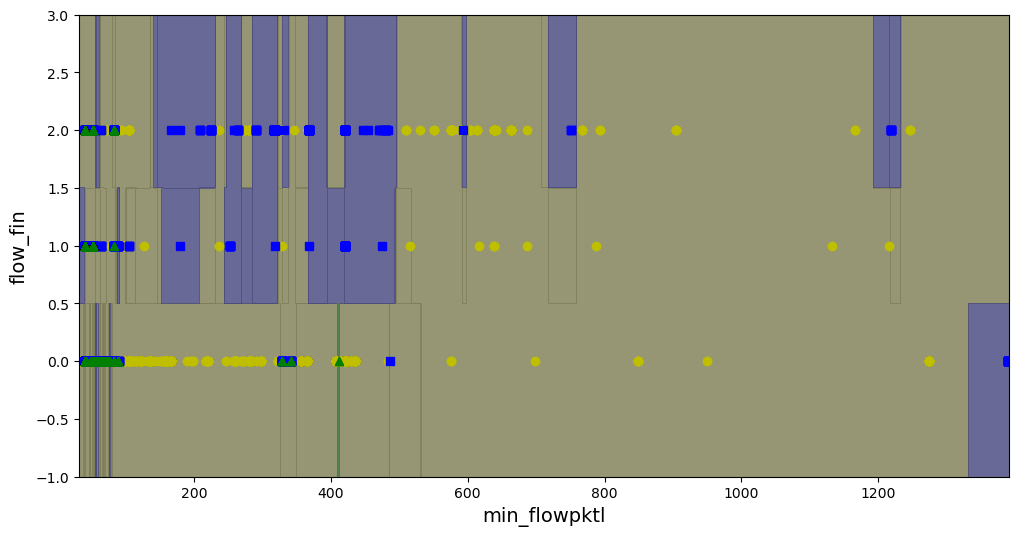

In [29]:
# Representamos gráficamente el límite de decisión construido

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_boundary(reg, X, y, plot_training=True, resolution=1000):
    mins = X.min(axis = 0) - 1
    maxs = X.max(axis = 0) + 1
    x1, x2 = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), (np.linspace(mins[1], maxs[1], resolution)))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = reg.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha = 0.3, cmap = custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
    plt.contourf(x1, x2, y_pred, alpha = 0.8, cmap = custom_cmap2)
    if plot_training:
        plt.plot(X[:,0][y==0], X[:,1][y==0], 'yo', label = 'normal')
        plt.plot(X[:,0][y==1], X[:,1][y==1], 'bs', label = 'adware')
        plt.plot(X[:,0][y==2], X[:,1][y==2], 'g^', label = 'malware')
        plt.axis([mins[0], maxs[0], mins[1], maxs[1]])
    plt.xlabel('min_flowpktl', fontsize = 14)
    plt.ylabel('flow_fin', fontsize = 14, )

plt.figure(figsize=(12,6))
plot_decision_boundary(reg_tree_reduced, X_train_reduced.values, y_train)
plt.show()

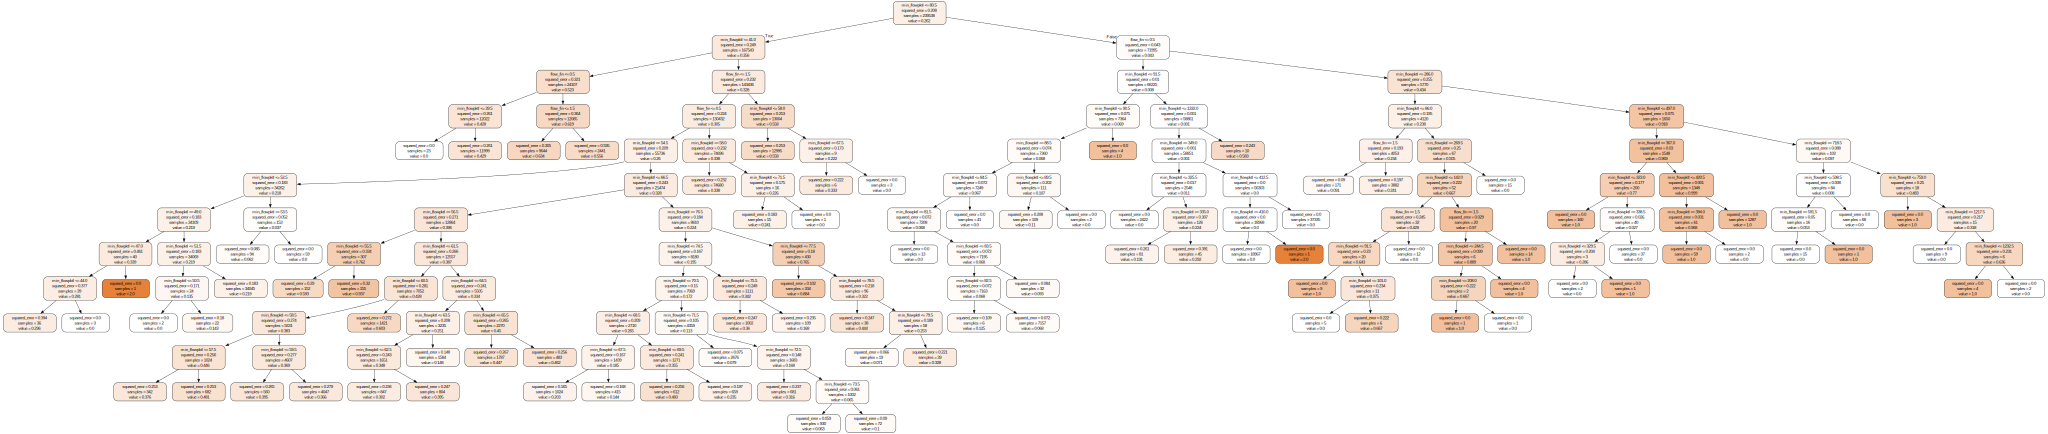

In [31]:
# Pintar el árbol para comporobar 

from graphviz import Source
from sklearn.tree import export_graphviz
import os

tree_to_visualize = reg_tree_reduced.estimators_[0]

export_graphviz(
    tree_to_visualize,
    out_file='android_malware.dot',
    feature_names = X_train_reduced.columns,
    class_names = ['benign', 'adware', 'malware'],
    rounded=True,
    filled=True,
)

Source.from_file('android_malware.dot')